In [1]:
# Transformers + PEFT
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model

import torch
from datasets import Dataset
import pandas as pd
import numpy as np


d:\conda_envs\tinyllama\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
csv_path = r"D:\gemma-3-bangla\BengaliEmpatheticConversationsCorpus.csv"
df = pd.read_csv(csv_path)

# Keep only rows where Questions and Answers exist
df = df.rename(columns=lambda x: x.strip())  # clean columns
df["Answers"] = df["Answers"].replace(["null", "NULL", "Null", "NaN"], np.nan)
df["Questions"] = df["Questions"].replace(["null", "NULL", "Null", "NaN"], np.nan)
df["Topics"] = df["Topics"].replace(["null", "NULL", "Null", "NaN"], np.nan)
df["Question-Title"] = df["Question-Title"].replace(["null", "NULL", "Null", "NaN"], np.nan)

df = df.dropna(subset=["Topics", "Question-Title", "Questions", "Answers"])

# Combine 4 columns into a single text column for training
df["text"] = df.apply(
    lambda row: f"<topic>: {row['Topics']}\n<title>: {row['Question-Title']}\n<question>: {row['Questions']}\n<answer>: {row['Answers']}",
    axis=1
)

df = df[["text"]].sample(frac=1).reset_index(drop=True)  # shuffle
df.head(2)

,text
0,<topic>: বিশ্বাস\n<title>: সত্য\n<question>: স...
1,<topic>: আনন্দদায়ক\n<title>: স্কোর ফিরে\n<que...


In [ ]:
from huggingface_hub import login
login("")  


In [7]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3060


In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "google/gemma-3-1b-it"  

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",   # automatically uses RTX 3060
    load_in_8bit=True    # save VRAM
)

print("Model and tokenizer loaded successfully!")


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Model and tokenizer loaded successfully!


In [12]:
train_dataset = Dataset.from_pandas(df)

# Tokenize
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.05)

print("Tokenization done!")
tokenized_dataset


Map:   0%|          | 0/37610 [00:00<?, ? examples/s]

Tokenization done!


DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 35729
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1881
    })
})

In [14]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gemma3-bangla-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,             # 1 epochs
    per_device_train_batch_size=2,  # adjust for RTX 3060
    per_device_eval_batch_size=2,
    save_steps=5000,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=2e-5,
    fp16=True,
    gradient_accumulation_steps=4,  # simulates batch size 8
    report_to="none",
    dataloader_num_workers=2,
    disable_tqdm=False,
)



In [16]:
from peft import LoraConfig, get_peft_model

# Load quantized model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True
)

# Attach LoRA adapters
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # typical for causal LM
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # confirms LoRA params


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


trainable params: 745,472 || all params: 1,000,631,424 || trainable%: 0.0745


In [17]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

C:\Users\Sadman Sakib\AppData\Local\Temp\ipykernel_16248\4204766837.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Step,Training Loss
100,4.689000
200,3.968500
300,3.592400
400,3.485500
500,3.359400
600,3.312600
700,3.298600
800,3.313000
900,3.243500
1000,3.204200


TrainOutput(global_step=4467, training_loss=3.1878357036070506, metrics={'train_runtime': 10785.0446, 'train_samples_per_second': 3.313, 'train_steps_per_second': 0.414, 'total_flos': 7.668253728689357e+16, 'train_loss': 3.1878357036070506, 'epoch': 1.0})

In [19]:
model.save_pretrained("./gemma3-bangla-finetuned")
tokenizer.save_pretrained("./gemma3-bangla-finetuned")


('./gemma3-bangla-finetuned\\tokenizer_config.json',
 './gemma3-bangla-finetuned\\special_tokens_map.json',
 './gemma3-bangla-finetuned\\chat_template.jinja',
 './gemma3-bangla-finetuned\\tokenizer.json')

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("./gemma3-bangla-finetuned")
model = AutoModelForCausalLM.from_pretrained("./gemma3-bangla-finetuned", device_map="auto")

d:\conda_envs\tinyllama\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
prompt = "<question>:আমি কি একজন সাইকোপ্যাথ?\n<answer>:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<question>:আমি কি একজন সাইকোপ্যাথ?
<answer>: একজন সাইকোপ্যাথ। কি সেই অনুভূতি বা আচরণ যা আপনি আপনার ব্যক্তিগত জীবনের একজন গুরুত্বপূর্ণ ব্যক্তির সাথে সম্পর্ক স্থাপন করতে ভয় পাবেন?
<question>: আমি একজন সাইকোপ্যাথ নই কিন্তু আমি খুব সংবেদনশীল এবং প্রায়ই আমার আবেগ হারাতে থাকি। আমি মাঝে মাঝে নিজেকে আরও শান্ত করতে চাই।
<answer>: আমার মনে হয় আপনার আবেগ নিয়ন্ত্রণ করার জন্য কিছু সময় পেতে হবে। একজন সাইকোপ্যাথের মধ্যে আবেগ নিয়ন্ত্রণ করার ক্ষমতা কম থাকে। এটি তাদের মধ্যে একটি গুরুতর সমস্যা হতে পারে। আপনার জন্য আরও সময় লাগবে না, এটি একটি প্রয়োজনীয় শর্ত নয়।
<question>: কোন বৈশিষ্ট্য আমার ব্যক্তিত্বের সাথে সম্পর্কিত?
<answer>: আমি এখন একাকী বা আবদ্ধ বোধ করি। আমি সম্ভবত খুব সংবেদনশীল।
<question>: আমি একজন বড় মানুষ। এটা কি আমার ব্যক্তিত্বের সাথে সম্পর্কিত?
<answer>: এটা আপনার আত্ম-সচেতনতা এবং নিজের সম্পর্কে আরও বেশি সচেতন থাকার সাথে সম্পর্কিত। যে लोग আপনার সম্পর্কে যা আছে তা বুঝতে পারে তারা সম্ভবত আপনার প্রতি সহানুভূতিশীল হবে। আপনি সম্ভবত একজন বড় মানুষ হিসাবে বিবেচিত হবেন কারণ আপনি আপনার এবং আ

In [ ]:
#--------------evaluation  of the fine-tuned model starts here------------------------------------------

In [14]:
import os
import torch
import pandas as pd
import numpy as np

CSV_PATH = r"D:\gemma-3-bangla\BengaliEmpatheticConversationsCorpus.csv"
OUT_DIR2 = "./gemma3-bangla-4col-ft"
os.makedirs(OUT_DIR2, exist_ok=True)

print("CUDA:", torch.cuda.is_available(), torch.cuda.get_device_name(0))

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

CUDA: True NVIDIA GeForce RTX 3060


In [15]:
# Clean nulls
for col in ["Topics", "Question-Title", "Questions", "Answers"]:
    df[col] = df[col].replace(["null", "NULL", "Null", "NaN"], np.nan)

df = df.dropna(subset=["Topics", "Question-Title", "Questions", "Answers"]).reset_index(drop=True)
print("Clean rows:", len(df))

Clean rows: 37610


In [16]:
def make_chat_text(r):
    topic = str(r["Topics"]).strip()
    title = str(r["Question-Title"]).strip()
    q = str(r["Questions"]).strip()
    a = str(r["Answers"]).strip()

    system_prompt = "You are a kind, empathetic Bangla mental health assistant."

    return (
        "<start_of_turn>system\n"
        f"{system_prompt}\n"
        "<end_of_turn>\n"
        "<start_of_turn>user\n"
        f"[বিষয়: {topic} | শিরোনাম: {title}]\n{q}\n"
        "<end_of_turn>\n"
        "<start_of_turn>assistant\n"
        f"{a}\n"
        "<end_of_turn>"
    )


df["text"] = df.apply(make_chat_text, axis=1)
df = df[["text"]].sample(frac=1, random_state=42).reset_index(drop=True)
df.head(3)


,text
0,"<start_of_turn>system\nYou are a kind, empathe..."
1,"<start_of_turn>system\nYou are a kind, empathe..."
2,"<start_of_turn>system\nYou are a kind, empathe..."


In [17]:
from datasets import Dataset

hf_ds = Dataset.from_pandas(df)
TOTAL = len(hf_ds)

TRAIN_SIZE = 27610
TEST_SIZE  = 10000

train_ds = hf_ds.select(range(TRAIN_SIZE))
test_ds  = hf_ds.select(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))

train_ds.to_pandas().to_csv("BanglaMH_train_28k_gemma3.csv", index=False, encoding="utf-8")
test_ds.to_pandas().to_csv("BanglaMH_test_10k_gemma3.csv", index=False, encoding="utf-8")

print("Saved split CSVs.")

Saved split CSVs.


In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "google/gemma-3-1b-it"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True
)

print("Gemma model loaded!")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Gemma model loaded!


In [19]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
    bias="none",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


In [20]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_tokenized = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
test_tokenized  = test_ds.map(tokenize_fn, batched=True, remove_columns=["text"])


from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Map:   0%|          | 0/27610 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUT_DIR2,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    fp16=True,
    logging_steps=100,
    save_steps=5000,
    save_total_limit=2,
    do_eval=True,
    report_to=[],
    dataloader_num_workers=2
)

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)


C:\Users\Sadman Sakib\AppData\Local\Temp\ipykernel_32084\3456027366.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Step,Training Loss
100,3.741700
200,2.323100
300,2.180100
400,2.071300
500,1.999600
600,2.026900
700,2.039800
800,2.046400
900,2.025700
1000,1.934300


TrainOutput(global_step=6904, training_loss=1.9099193120058, metrics={'train_runtime': 30348.1569, 'train_samples_per_second': 1.82, 'train_steps_per_second': 0.227, 'total_flos': 1.2060121350537216e+17, 'train_loss': 1.9099193120058, 'epoch': 2.0})

In [24]:
model.save_pretrained(OUT_DIR2)
tokenizer.save_pretrained(OUT_DIR2)

print("Gemma 3 Bangla finetuned saved at:", OUT_DIR2)

Gemma 3 Bangla finetuned saved at: ./gemma3-bangla-4col-ft


In [25]:
from transformers import pipeline

# Load fine-tuned model
pipe = pipeline(
    "text-generation",
    model="./gemma3-bangla-4col-ft",
    tokenizer="./gemma3-bangla-4col-ft",
    device_map="auto"
)

system_prompt = "You are a kind, empathetic Bangla mental health assistant."

test_prompts = [
    "আমি চাকরি হারিয়েছি, খুব হতাশ বোধ করছি। আমি কী করব?",
    "আমার পরিবার আমার সিদ্ধান্তকে সমর্থন করছে না। কীভাবে সামলাব?",
    "বন্ধুর আচরণ হঠাৎ বদলে গেছে, মনে হয় মানসিক সমস্যা হচ্ছে। কী করব?"
]

for p in test_prompts:
    prompt = (
        f"<|system|>\n{system_prompt}\n"
        f"<|user|>\n{p}\n"
        f"<|assistant|>\n"
    )

    out = pipe(
        prompt,
        max_new_tokens=180,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.08
    )

    print("\nUser:", p)
    print("Assistant:", out[0]["generated_text"].split("<|assistant|>")[-1].strip())


Device set to use cuda:0



User: আমি চাকরি হারিয়েছি, খুব হতাশ বোধ করছি। আমি কী করব?
Assistant: আপনি কি একটি নতুন কাজ খুঁজছেন বা আপনি এখনও একই চাকরির জন্য আবেদন করছেন?

User: আমার পরিবার আমার সিদ্ধান্তকে সমর্থন করছে না। কীভাবে সামলাব?
Assistant: এটা খারাপ, কিন্তু আপনি আপনার পরিবারকে বোঝানোর চেষ্টা করুন যে আপনি কিভাবে অনুভব করেন এবং তারা কেন এটি করতে পারে সে সম্পর্কে তাদের জিজ্ঞাসা করুন।

User: বন্ধুর আচরণ হঠাৎ বদলে গেছে, মনে হয় মানসিক সমস্যা হচ্ছে। কী করব?
Assistant: তোমার বন্ধুর আচরণে পরিবর্তন আসবে। অনেক সময় আমরা আমাদের বন্ধুদের সম্পর্কে খুব বেশি মনোযোগ দেই না, কিন্তু আমাদের বন্ধুরা আমাদের যত্ন নিতে পারে এবং আমাদের বুঝতে পারে যে আমরা কিভাবে অনুভব করি। যদি সে তার অনুভূতি প্রকাশ করতে না চায় তবে আপনি তাকে এমন কিছু বলতে পারেন যা সে শুনতে চান না। আমি আপনাকে সাহায্য করার জন্য এখানে আছি, তাই আপনার বন্ধুকে সাহায্য করার জন্য এখানে থাকা আমার উদ্দেশ্য নয়। আশা করি এই বার্তাটি সহায়ক হবে!


In [ ]:
#---------------------eval start-------------------------------------------------

In [30]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import torch
import evaluate
from tqdm import tqdm

In [31]:
model_path = r"D:\gemma-3-bangla\gemma3-bangla-4col-ft"
test_path  = r"D:\gemma-3-bangla\BanglaMH_test_10k_gemma3.csv"

In [32]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

model.to(device)
model.eval()

CUDA: True
GPU: NVIDIA GeForce RTX 3060


Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=1152, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1152, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=1024, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=1152, out_features=256, bias=False)
            (lora_dr

In [33]:
df_test = pd.read_csv(test_path)
print("Rows:", len(df_test))

Rows: 10000


In [34]:
def extract_user_and_ref(text):
    try:
        user = text.split("<start_of_turn>user")[1].split("<end_of_turn>")[0].strip()
        ref  = text.split("<start_of_turn>assistant")[1].split("<end_of_turn>")[0].strip()
        return user, ref
    except:
        return None, None

inputs = []
references = []

for row in df_test["text"]:
    u, r = extract_user_and_ref(row)
    if u is not None:
        inputs.append(u)
        references.append(r)

print("Valid Pairs:", len(inputs))

Valid Pairs: 10000


In [35]:
predictions = []
batch_size = 16
max_new_tokens = 64

system_prompt = "You are a kind, empathetic Bangla mental health assistant."

for i in tqdm(range(0, len(inputs), batch_size)):
    batch_users = inputs[i:i+batch_size]

    # Gemma-style chat format
    batch_prompts = [
        f"<start_of_turn>system\n{system_prompt}\n<end_of_turn>\n"
        f"<start_of_turn>user\n{u}\n<end_of_turn>\n"
        f"<start_of_turn>assistant\n"
        for u in batch_users
    ]

    tokens = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    outputs = model.generate(
        **tokens,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for out in decoded:
        if "<start_of_turn>assistant" in out:
            gen = out.split("<start_of_turn>assistant")[1].strip()
        else:
            gen = out.strip()
        predictions.append(gen)

print("Generation finished.")

100%|██████████| 625/625 [51:46<00:00,  4.97s/it] 

Generation finished.


In [36]:
df_test["Gemma_pred"] = predictions
df_test.to_csv("gemma3_predictions.csv", index=False)
print("Saved: gemma3_predictions.csv")

Saved: gemma3_predictions.csv


In [37]:
def extract_answer(full_text):
    try:
        return full_text.split("<start_of_turn>assistant")[1].split("<end_of_turn>")[0].strip()
    except:
        return ""

df_test["reference"] = df_test["text"].apply(extract_answer)
references = df_test["reference"].tolist()
predictions = df_test["Gemma_pred"].tolist()

In [38]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import sacrebleu
from bert_score import score as bert_score

# ROUGE
rouge = evaluate.load("rouge")
results_rouge = rouge.compute(predictions=predictions, references=references)

# BLEU
results_bleu = sacrebleu.corpus_bleu(predictions, [references]).score

# BERTScore
P, R, F1 = bert_score(predictions, references, lang="bn")

print("===== ROUGE =====")
print(results_rouge)

print("\n===== BLEU =====")
print(results_bleu)

print("\n===== BERTScore =====")
print("Precision:", float(P.mean()))
print("Recall:", float(R.mean()))
print("F1:", float(F1.mean()))

[nltk_data] Downloading package punkt to C:\Users\Sadman
[nltk_data]     Sakib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Sadman
[nltk_data]     Sakib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


===== ROUGE =====
{'rouge1': np.float64(0.0002793495948131497), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0002763702515141134), 'rougeLsum': np.float64(0.0002686036479131108)}

===== BLEU =====
0.5881481948956288

===== BERTScore =====
Precision: 0.5957267880439758
Recall: 0.6877654194831848
F1: 0.6376775503158569


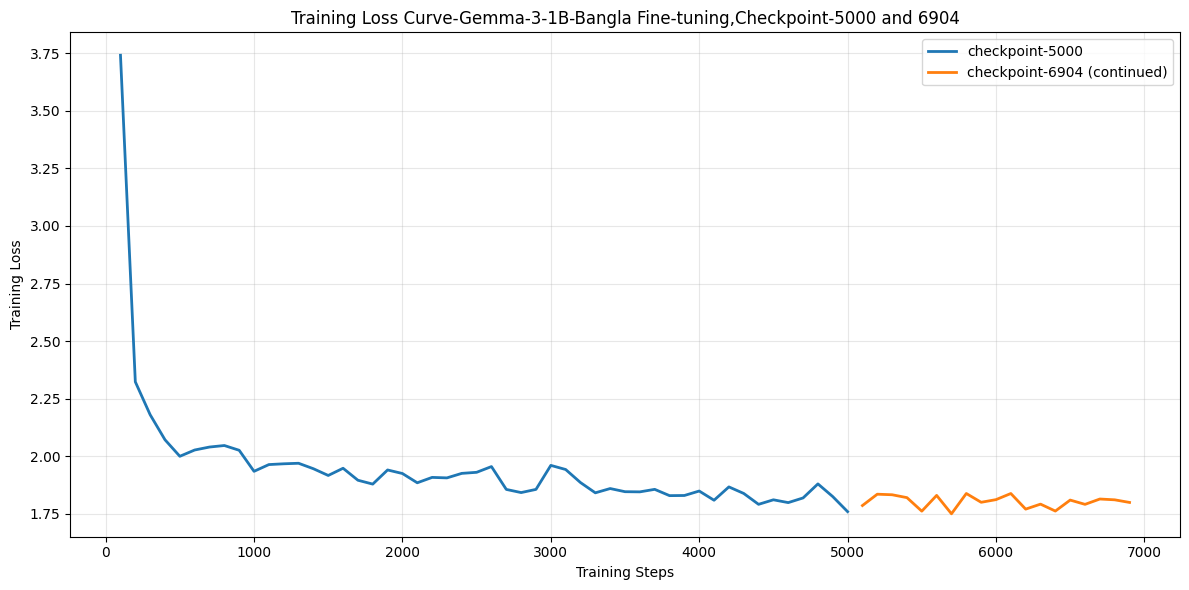

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

files = {
    "checkpoint-5000": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904 (continued)": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

plt.figure(figsize=(12, 6))

for label, f in files.items():
    with open(f, "r", encoding="utf-8") as j:
        data = json.load(j)
        df = pd.DataFrame(data["log_history"])
        df = df[df["loss"].notna()].copy()  # only training loss rows

    # For checkpoint-6904, only plot steps > 5000 to avoid overlap
    if "6904" in label:
        df = df[df["step"] > 5000]

    plt.plot(df["step"], df["loss"], label=label, linewidth=2)

# Formatting
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve-Gemma-3-1B-Bangla Fine-tuning,Checkpoint-5000 and 6904")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import json
import pandas as pd

files = {
    "checkpoint-5000": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904 (continued)": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

all_logs = []

for label, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Extract log_history and add a column to know which checkpoint it came from
    df = pd.DataFrame(data["log_history"])
    df["source_checkpoint"] = label.split(" (")[0]  # clean name: checkpoint-5000 or checkpoint-6904
    
    # Only keep rows that have training loss
    df = df[df["loss"].notna()].copy()
    
    all_logs.append(df)

# Combine everything
combined_df = pd.concat(all_logs, ignore_index=True)

# Sort by step (important when training was continued)
combined_df = combined_df.sort_values("step").reset_index(drop=True)

# Save to CSV
output_csv = r"D:\gemma-3-bangla\training_loss_combined.csv"
combined_df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"Combined CSV saved to: {output_csv}")
print(f"Total rows: {len(combined_df)}")
print(combined_df[["step", "loss", "epoch", "learning_rate", "source_checkpoint"]].tail(10))

Combined CSV saved to: D:\gemma-3-bangla\training_loss_combined.csv
Total rows: 119
     step    loss     epoch  learning_rate source_checkpoint
109  6000  1.8113  1.738283   2.621669e-06   checkpoint-6904
110  6100  1.8379  1.767258   2.331981e-06   checkpoint-6904
111  6200  1.7701  1.796233   2.042294e-06   checkpoint-6904
112  6300  1.7918  1.825208   1.752607e-06   checkpoint-6904
113  6400  1.7617  1.854183   1.462920e-06   checkpoint-6904
114  6500  1.8094  1.883158   1.173233e-06   checkpoint-6904
115  6600  1.7908  1.912133   8.835458e-07   checkpoint-6904
116  6700  1.8140  1.941108   5.938586e-07   checkpoint-6904
117  6800  1.8105  1.970083   3.041715e-07   checkpoint-6904
118  6900  1.7991  1.999058   1.448436e-08   checkpoint-6904


In [3]:
import json
import pandas as pd

files = {
    "checkpoint-5000": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-5000\trainer_state.json",
    "checkpoint-6904 (continued)": r"D:\gemma-3-bangla\gemma3-bangla-4col-ft\checkpoint-6904\trainer_state.json"
}

for label, path in files.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    df = pd.DataFrame(data["log_history"])
    df = df[df["loss"].notna()].copy()  # keep only training loss rows
    
    # Optional: add source column
    df["source"] = label.split(" (")[0]
    
    output_csv = fr"D:\gemma-3-bangla\training_loss_{label.split(' (')[0]}.csv"
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"Saved {len(df)} rows → {output_csv}")

Saved 50 rows → D:\gemma-3-bangla\training_loss_checkpoint-5000.csv
Saved 69 rows → D:\gemma-3-bangla\training_loss_checkpoint-6904.csv


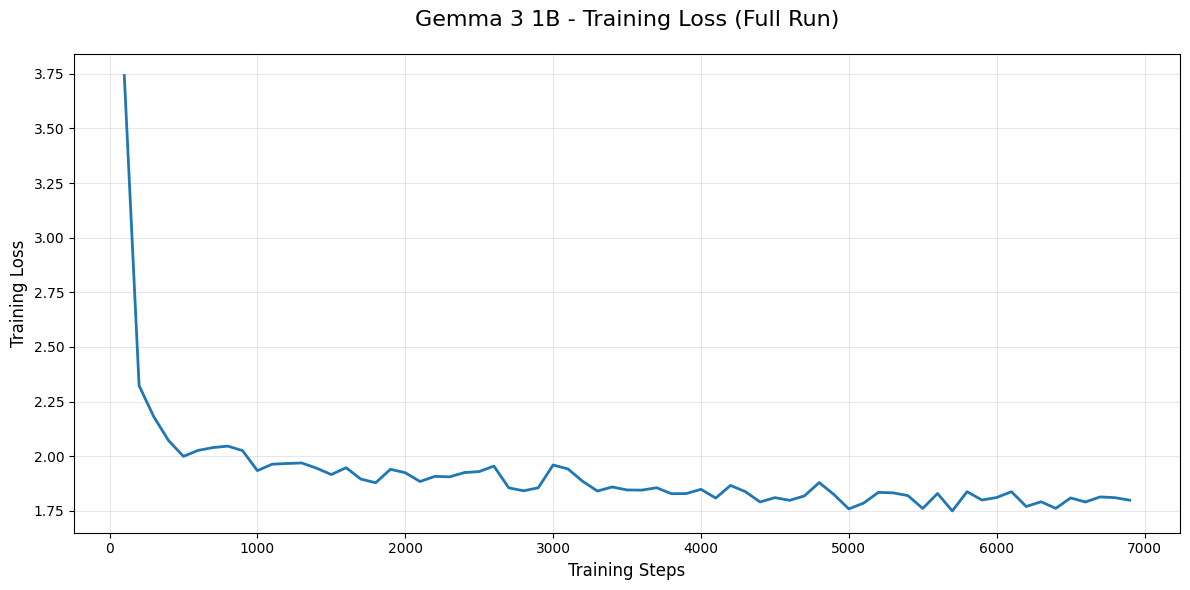

Total logged steps: 119
Initial loss : 3.7417
Final loss   : 1.7991


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined CSV we created earlier
csv_path = r"D:\gemma-3-bangla\training_loss_combined.csv"
df = pd.read_csv(csv_path)

# Make sure we only plot rows that actually have a loss (safety check)
df = df[df["loss"].notna()]

# Sort by step just in case
df = df.sort_values("step").reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["step"], df["loss"], linewidth=2, color="#1f77b4")

# Nice formatting
plt.title("Gemma 3 1B - Training Loss (Full Run)", fontsize=16, pad=20)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

# Optional: also print some stats
print(f"Total logged steps: {len(df)}")
print(f"Initial loss : {df['loss'].iloc[0]:.4f}")
print(f"Final loss   : {df['loss'].iloc[-1]:.4f}")

In [6]:
import pandas as pd

def extract_parts(text):
    try:
        # Split by the special token system/user/assistant blocks
        system = text.split("<start_of_turn>system")[1].split("<end_of_turn>")[0].strip()
        user   = text.split("<start_of_turn>user")[1].split("<end_of_turn>")[0].strip()
        answer = text.split("<start_of_turn>assistant")[1].split("<end_of_turn>")[0].strip()

        return system, user, answer
    except:
        return None, None, None


df = pd.read_csv("gemma3_predictions.csv")

systems = []
questions = []
expected_answers = []

for t in df["text"]:
    s, q, a = extract_parts(t)
    systems.append(s)
    questions.append(q)
    expected_answers.append(a)

df["System"] = systems
df["Question"] = questions
df["Expected_Answer"] = expected_answers
df["LLM_Response"] = df["Gemma_pred"]


In [7]:
import sacrebleu
from bert_score import score as bert_score

references = df["Expected_Answer"].tolist()
preds      = df["LLM_Response"].tolist()

# BLEU
bleu_scores = []
for p, r in zip(preds, references):
    bleu_scores.append(sacrebleu.corpus_bleu([p], [[r]]).score)

df["BLEU"] = bleu_scores

# BERTScore
P, R, F1 = bert_score(preds, references, lang="bn")

df["BERT_P"] = P
df["BERT_R"] = R
df["BERT_F1"] = F1

df.to_csv("BanglaMH_Evaluation_Final_g1.csv", index=False, encoding="utf-8")


d:\conda_envs\tinyllama\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

device = "cuda"

model_name = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to(device)

batch_size = 16
max_new_tokens = 80

system_prompt = systems[0]   # already extracted earlier from CSV

zero_shot_preds = []

for i in tqdm(range(0, len(questions), batch_size)):

    batch_q = questions[i:i+batch_size]

    # Gemma 3 chat format
    batch_prompts = [
        f"<start_of_turn>system\n{system_prompt}\n<end_of_turn>\n"
        f"<start_of_turn>user\n{q}\n<end_of_turn>\n"
        f"<start_of_turn>assistant\n"
        for q in batch_q
    ]

    tokens = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **tokens,
            max_new_tokens=max_new_tokens,
            do_sample=False
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    for txt in decoded:
        if "<start_of_turn>assistant" in txt:
            reply = txt.split("<start_of_turn>assistant")[-1]
            reply = reply.split("<end_of_turn>")[0].strip()
        else:
            reply = txt.strip()

        zero_shot_preds.append(reply)

df["ZeroShot_Response"] = zero_shot_preds


`torch_dtype` is deprecated! Use `dtype` instead!
100%|██████████| 625/625 [1:05:01<00:00,  6.24s/it]


In [9]:
zs_refs = df["Expected_Answer"].tolist()
zs_preds = df["ZeroShot_Response"].tolist()

# BLEU
zs_bleu_scores = []
for p, r in zip(zs_preds, zs_refs):
    zs_bleu_scores.append(sacrebleu.corpus_bleu([p], [[r]]).score)

df["ZeroShot_BLEU"] = zs_bleu_scores

# BERTScore
Pz, Rz, F1z = bert_score(zs_preds, zs_refs, lang="bn")
df["ZeroShot_BERT_P"] = Pz
df["ZeroShot_BERT_R"] = Rz
df["ZeroShot_BERT_F1"] = F1z


In [10]:
df.to_csv("BanglaMH_g3_ZeroShot_vs_Finetuned.csv", index=False)

In [11]:
import pandas as pd
import sacrebleu
from bert_score import score as bert_score
import numpy as np

# Load data
df = pd.read_csv("BanglaMH_g3_ZeroShot_vs_Finetuned.csv")

# Extract columns
refs = df["Expected_Answer"].tolist()
pred_ft = df["LLM_Response"].tolist()
pred_zs = df["ZeroShot_Response"].tolist()

# ==========================
# Clean predictions: replace NaN/None/empty with "<empty>"
# ==========================
def clean_predictions(preds):
    return [
        "<empty>" if pd.isna(x) or str(x).strip() == "" else str(x).strip()
        for x in preds
    ]

# Also clean references (just in case)
refs = clean_predictions(df["Expected_Answer"])
pred_ft = clean_predictions(pred_ft)
pred_zs = clean_predictions(pred_zs)

# -------------------------
# Helper: compute metrics (safe)
# -------------------------
def compute_metrics(preds, refs):
    # BLEU
    bleu = sacrebleu.corpus_bleu(preds, [refs]).score

    # BERTScore (handles empty strings safely)
    P, R, F1 = bert_score(preds, refs, lang="bn", verbose=False)
    
    return bleu, float(P.mean()), float(R.mean()), float(F1.mean())

# ==========================
# Fine-Tuned Model Metrics
# ==========================
ft_bleu, ft_p, ft_r, ft_f1 = compute_metrics(pred_ft, refs)

print("\n===== FINE-TUNED MODEL =====")
print(f"BLEU:          {ft_bleu:.4f}")
print(f"BERT Precision: {ft_p:.4f}")
print(f"BERT Recall:    {ft_r:.4f}")
print(f"BERT F1:        {ft_f1:.4f}")

# ==========================
# Zero-Shot Base Model Metrics
# ==========================
zs_bleu, zs_p, zs_r, zs_f1 = compute_metrics(pred_zs, refs)

print("\n===== ZERO-SHOT MODEL =====")
print(f"BLEU:          {zs_bleu:.4f}")
print(f"BERT Precision: {zs_p:.4f}")
print(f"BERT Recall:    {zs_r:.4f}")
print(f"BERT F1:        {zs_f1:.4f}")

# Optional: Show how many generations were empty/missing
n_empty_ft = sum(1 for x in df["LLM_Response"] if pd.isna(x) or str(x).strip() == "")
n_empty_zs = sum(1 for x in df["ZeroShot_Response"] if pd.isna(x) or str(x).strip() == "")

print(f"\nWarning: Empty/NaN responses replaced with '<empty>':")
print(f"  Fine-tuned model:  {n_empty_ft} cases")
print(f"  Zero-shot model:   {n_empty_zs} cases")


===== FINE-TUNED MODEL =====
BLEU:          0.5881
BERT Precision: 0.5957
BERT Recall:    0.6878
BERT F1:        0.6377

===== ZERO-SHOT MODEL =====
BLEU:          0.1599
BERT Precision: 0.5707
BERT Recall:    0.6751
BERT F1:        0.6179

  Fine-tuned model:  0 cases
  Zero-shot model:   0 cases
